## Imports

In [3]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

from selenium.webdriver.edge.options import Options
import time
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

import json
import elemental
import urllib.parse as urlparse
from urllib.parse import parse_qs


## Definitions

In [4]:
def random_portfolio(symbols_list,data,n):
    sample = random.sample(symbols_list,n)
    return data[sample]

In [5]:
def portfolio_opti(portfolio):
    # Sample 10 stocks
    stocks = random.sample(symbols, 10)
    
    # Download daily price data for each of the stocks in the portfolio
    data = yf.download(stocks, start='2023-01-01')['Adj Close']
    data.sort_index(inplace=True)
    
    # Convert daily stock prices into daily returns
    returns = data.pct_change()
    
    # Calculate mean daily return and covariance of daily returns
    mean_daily_returns = returns.mean()
    cov_matrix = returns.cov()
    
    # Set number of runs of random portfolio weights
    num_portfolios = 25000
    
    # Set up array to hold results
    # The number of rows is 3 (for 'ret', 'stdev', 'sharpe') plus the number of stocks
    num_stocks = len(stocks)
    results = np.zeros((3 + num_stocks, num_portfolios))
    
    for i in range(num_portfolios):
        # Select random weights for portfolio holdings
        weights = np.random.random(num_stocks)
        # Rebalance weights to sum to 1
        weights /= np.sum(weights)
        
        # Calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
        
        # Store results in results array
        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        # Store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results[2, i] = results[0, i] / results[1, i]
        # Iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results[j + 3, i] = weights[j]
    
    # Convert results array to Pandas DataFrame
    column_names = ['ret', 'stdev', 'sharpe'] + stocks
    results_frame = pd.DataFrame(results.T, columns=column_names)
    
    # Locate position of portfolio with highest Sharpe Ratio
    max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
    
    # Locate position of portfolio with minimum standard deviation
    min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
    
    # Print the weights of the portfolio with the highest Sharpe ratio
    print("Portfolio with the highest Sharpe Ratio (Red Star):")
    for stock, weight in max_sharpe_port[3:].items():
        print(f"{stock}: {weight:.2%}")
    print("\n")
    
    # Print the weights of the portfolio with the minimum variance
    print("Portfolio with the Minimum Variance (Green Star):")
    for stock, weight in min_vol_port[3:].items():
        print(f"{stock}: {weight:.2%}")
    print("\n")
    
    # Create scatter plot coloured by Sharpe Ratio
    plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='RdYlBu')
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.colorbar()
    
    # Plot red star to highlight position of portfolio with highest Sharpe Ratio
    plt.scatter(max_sharpe_port['stdev'], max_sharpe_port['ret'], marker=(5, 1, 0), color='r', s=500)
    
    # Plot green star to highlight position of minimum variance portfolio
    plt.scatter(min_vol_port['stdev'], min_vol_port['ret'], marker=(5, 1, 0), color='g', s=500)
    
    plt.show()


In [6]:
def portfolio_corr_matrix(portfolio):
    correlation_matrix = portfolio.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(25, 25))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
    plt.title('ETF Correlation Heatmap')

In [7]:
def portfolio_individual_plot(portfolio):
    symbols = list(portfolio.columns)
    plt.figure(figsize=(25, 15))
    for ticker in symbols:
        portfolio[f"{ticker}"].plot(label=ticker)

    plt.title("ETFs Time Series Comparison")
    plt.legend()

In [8]:
def portfolio_top_corr(portfolio,order = True):
    correlation_values = (portfolio.corr()).unstack()
    sorted_correlation_values = correlation_values[correlation_values != 1.0].sort_values(ascending=order)

    top_correlations = sorted_correlation_values.drop_duplicates()
    
    return top_correlations

In [9]:
def portfolio_performance(portfolio):
    returns = portfolio.pct_change()
    alphas = .05*np.ones(returns.shape[1])
    portfolio = np.random.dirichlet(alphas, size=1)
    
    plt.plot(returns.fillna(0).dot(portfolio.T).add(1).cumprod().sub(1), color='r')
    plt.title('Random Portfolio Performance')
    plt.xlabel('Time (days)')
    plt.ylabel('Return')

In [10]:
def get_quote(symbol):
    msft = yf.Ticker(symbol)
    try:
        hist = msft.history(period="2d")
    except json.decoder.JSONDecodeError:
        return None
    try:
        hist.reset_index(inplace=True)
        jsdata = json.loads(hist.to_json())
        return jsdata["Close"]["0"]
    except (ValueError, KeyError) as e:
       return None

In [11]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.edge.options import Options
import time
import urllib.parse as urlparse
from urllib.parse import parse_qs

def web_lookup(isin):
    # Specify the path to the Edge WebDriver executable
    msedgedriver_path = "C:\\Users\\Irish\\Downloads\\edgedriver_win32\\msedgedriver.exe"
    service = Service(msedgedriver_path)

    # Configure Edge options
    options = Options()
    options.add_argument("--incognito")
    options.add_argument("--disable-notifications")

    # Create an instance of the Edge browser with the specified options and service
    browser = webdriver.Edge(service=service, options=options)

    # Visit the Yahoo Finance lookup page
    browser.get("https://finance.yahoo.com/lookup")

    # Fill in the search input with the ISIN and submit the form
    search_input = browser.find_element_by_id("yfin-usr-qry")
    search_input.send_keys(isin)
    submit_button = browser.find_element_by_type("submit")
    submit_button.click()

    # Wait for the page to load
    time.sleep(5)

    # Parse the current URL of the browser
    parsed = urlparse.urlparse(browser.current_url)
    try:
        # Attempt to extract the ticker symbol from the query parameters
        ticker = parse_qs(parsed.query)['p'][0]
    except KeyError:
        # If the ticker is not found, default to "n/a"
        ticker = "n/a"

    # Close the browser
    browser.quit()

    return ticker


In [12]:
import requests


def get_symbol_for_isin(isin):
    url = 'https://query1.finance.yahoo.com/v1/finance/search'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.109 Safari/537.36',
    }
    params = dict(
        q=isin,
        quotesCount=1,
        newsCount=0,
        listsCount=0,
        quotesQueryId='tss_match_phrase_query'
    )
    resp = requests.get(url=url, headers=headers, params=params)
    data = resp.json()
    if 'quotes' in data and len(data['quotes']) > 0:
        return data['quotes'][0]['symbol']
    else:
        return None

In [13]:
print(get_symbol_for_isin("DWS Invest Brazilian Equities LC Eur Cap"))

KTCAX


## Main

In [14]:
intraday_price = True
morningstar_performance = True
region = True
avg_vol_3mo = False
category = False
volume = False
price_end_day = False
volume_end_day = False
exchange = False
week_price_change = False
company = False
net_assets = False
initial_minimum_investment = False
price = False
intraday_price_change = False
long_market_cap_val = False
intraday_price_change_percentage = False
symbol = False

In [15]:
# Spécifiez le chemin vers msedgedriver
msedgedriver_path = "C:\\Users\\Irish\\Downloads\\edgedriver_win32\\msedgedriver.exe"
service = Service(msedgedriver_path)

# Configurez les options de Edge
options = Options()
options.add_argument("--incognito")
options.add_argument("--disable-notifications")

# Créez une instance du navigateur Edge avec les options et le service spécifiés
browser = webdriver.Edge(service=service, options=options)

# URL de la page de connexion
path = "https://login.yahoo.com/config/login?.src=finance&.intl=us&.lang=en-US&.done=https%3A%2F%2Ffinance.yahoo.com%2Fquotes%2Flogin%2Fview%2Fv1%2F"
browser.get(path)

# Remplissez le formulaire de connexion
WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.NAME, "username"))).send_keys("irishrugbyman@gmail.com")
WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.NAME, "signin"))).click()
WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.NAME, "password"))).send_keys("F$Pi2YahooFinance20")
WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.ID, "login-signin"))).click()

# Accédez à l'URL de la page du screener Yahoo Finance
url = "https://finance.yahoo.com/screener/1745ba28-6f7f-4504-a2db-9a98b89ff912?offset=0&count=100"
browser.get(url)

# Attendez que la page charge et que le tableau soit présent
time.sleep(5)
# Utilisez WebDriverWait et EC pour une approche plus robuste

# Récupérez le contenu HTML de la page
content = browser.page_source

# Utilisez pandas pour lire le tableau directement à partir du contenu HTML
dfs = pd.read_html(content)
df = dfs[0]

# Fermez le navigateur
browser.quit()

# Récupérez la liste des symboles
symbols = df["Symbol"].tolist()

# Utilisez yfinance pour télécharger les données des ETFs
etf_data = yf.download(symbols, start='2023-01-01')['Adj Close']
etf_data

[*********************100%%**********************]  100 of 100 completed


,0050.TW,0052.TW,0053.TW,006208.TW,00692.TW,00735.TW,1311.T,1319.T,1320.T,1321.T,...,XUCS.DE,XUHC.DE,XUTC.SW,ZCS-L.TO,ZJK-U.TO,ZPDF.DE,ZPDH.DE,ZPDS.DE,ZPR5.DE,ZWP.TO
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.320000,52.189999,NaN,NaN,NaN,37.009998,38.360001,34.875000,24.802000,NaN
2023-01-03,104.320137,89.784225,50.927036,60.789806,25.545446,22.011660,NaN,NaN,NaN,NaN,...,38.855000,51.529999,NaN,NaN,16.200001,36.904999,37.919998,34.415001,25.048000,15.405761
2023-01-04,104.084648,89.399292,50.878399,60.547035,25.498140,22.194633,903.059204,325.597626,26074.525391,26155.736328,...,39.110001,51.830002,NaN,NaN,16.510000,37.419998,38.139999,34.685001,24.969999,15.462193
2023-01-05,104.838203,90.121033,51.267525,60.984024,25.611675,22.295271,904.239929,328.920044,26162.914062,26288.406250,...,38.915001,51.540001,NaN,NaN,16.510000,37.115002,37.884998,34.505001,25.077999,15.452786
2023-01-06,105.309181,90.602188,51.608009,61.372459,25.772518,22.606321,910.143555,324.522705,26344.601562,26416.162109,...,39.605000,51.480000,NaN,NaN,16.450001,37.570000,37.860001,35.095001,25.021999,15.650296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12,129.627213,126.550003,70.250000,75.699997,31.910000,28.945959,1281.000000,427.500000,36740.000000,36890.000000,...,37.630001,51.770000,NaN,22.860001,17.320000,39.404999,38.505001,33.299999,24.686001,17.490000
2024-01-15,129.627213,126.550003,70.250000,75.699997,31.910000,28.945959,1290.500000,429.399994,36840.000000,36980.000000,...,37.744999,51.860001,NaN,22.900000,17.320000,39.424999,38.584999,33.404999,24.719999,17.559999
2024-01-16,128.649994,126.300003,69.900002,75.199997,31.719999,28.840002,1297.500000,436.000000,36870.000000,36990.000000,...,37.875000,52.060001,NaN,22.910000,17.320000,39.520000,38.730000,33.514999,24.812000,17.420000


In [16]:
test = ["FR0010149302","LU0616856935"]
test_data = yf.download(test, start='2023-01-01')['Adj Close']
test_data

[*********************100%%**********************]  2 of 2 completed


,FR0010149302,LU0616856935
Date,,
2024-01-17,1089.225952,166.050995


In [17]:
ran_port = (random_portfolio(symbols,etf_data,10))

ran_port = ran_port.bfill()
ran_port

,XUTC.SW,CGB.MI,JPPA.DE,1320.T,LQDG.L,ZPDS.DE,CVD.TO,1676.T,1321.T,0052.TW
Date,,,,,,,,,,
2023-01-02,78.150002,20.305000,99.470001,26074.525391,79.985001,34.875000,15.785263,17955.0,26155.736328,89.784225
2023-01-03,78.150002,20.500000,100.485001,26074.525391,79.985001,34.415001,15.785263,17955.0,26155.736328,89.784225
2023-01-04,78.150002,20.465000,99.942001,26074.525391,79.625000,34.685001,15.709420,17955.0,26155.736328,89.399292
2023-01-05,78.150002,20.650000,100.699997,26162.914062,80.529999,34.505001,15.680980,17955.0,26288.406250,90.121033
2023-01-06,78.150002,20.650000,99.919998,26344.601562,79.824997,35.095001,15.662014,17955.0,26416.162109,90.602188
...,...,...,...,...,...,...,...,...,...,...
2024-01-12,73.209999,19.228001,101.680000,36740.000000,80.050003,33.299999,16.070000,18840.0,36890.000000,126.550003
2024-01-15,73.209999,19.254000,101.900002,36840.000000,80.300003,33.404999,16.129999,18840.0,36980.000000,126.550003
2024-01-16,73.209999,19.278000,102.464996,36870.000000,80.625000,33.514999,16.080000,18800.0,36990.000000,126.300003


[*********************100%%**********************]  10 of 10 completed
Portfolio with the highest Sharpe Ratio (Red Star):
1349.T: 25.06%
CVD.TO: 3.47%
1676.T: 2.82%
DXF.TO: 11.89%
ZCS-L.TO: 23.10%
XAW-U.TO: 2.45%
DXP.TO: 4.71%
PQVM.MI: 22.59%
IS3L.DE: 3.72%
XLFS.MI: 0.20%


Portfolio with the Minimum Variance (Green Star):
1349.T: 2.63%
CVD.TO: 4.92%
1676.T: 8.04%
DXF.TO: 4.80%
ZCS-L.TO: 16.42%
XAW-U.TO: 18.99%
DXP.TO: 0.03%
PQVM.MI: 4.50%
IS3L.DE: 7.31%
XLFS.MI: 32.36%


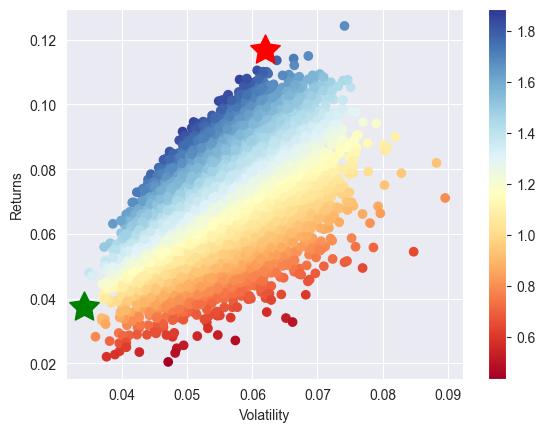

In [18]:
portfolio_opti(ran_port)

In [19]:
covariance = np.cov(ran_port.fillna(0).T)

In [20]:
portfolio_volatility = np.sqrt(np.dot(np.dot(ran_port, covariance), ran_port.T))

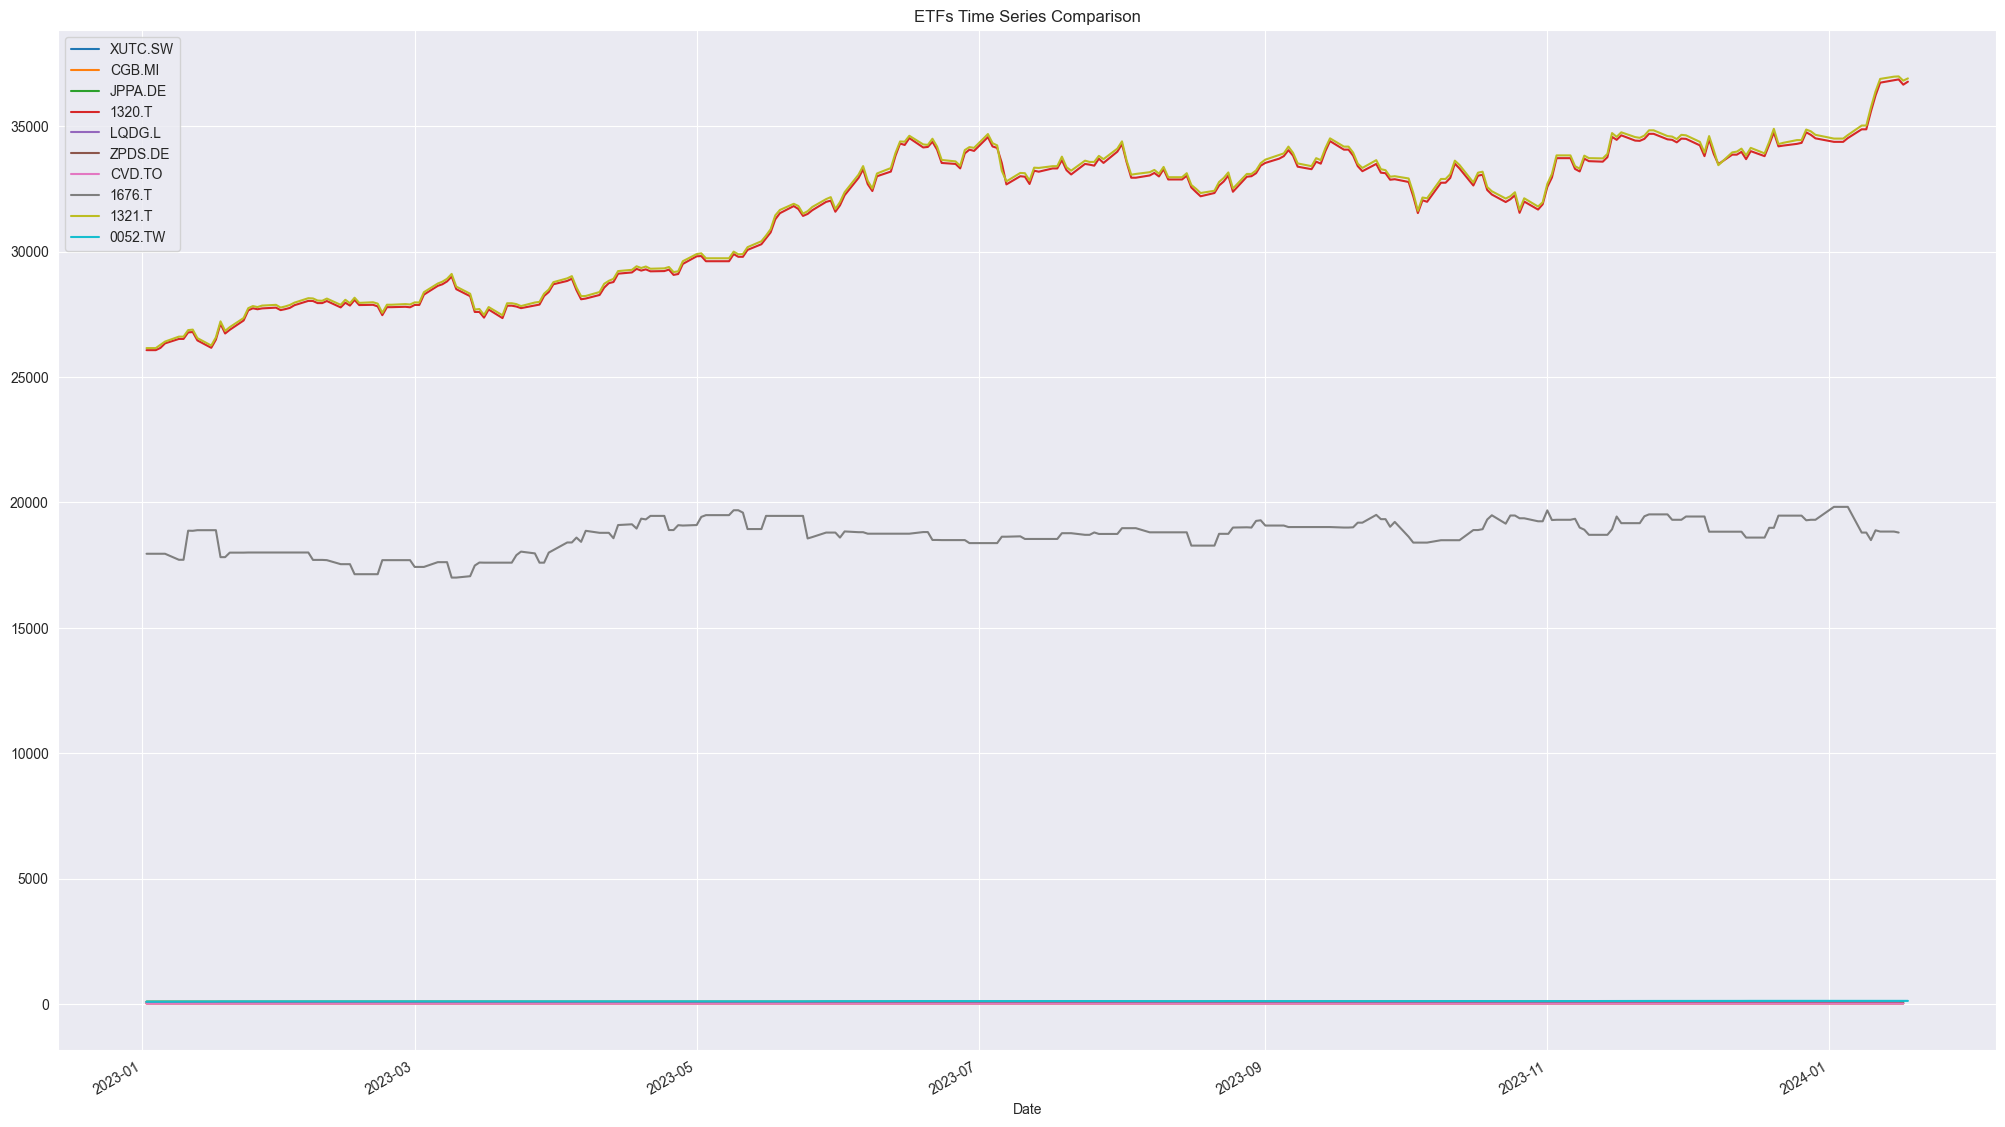

In [21]:
portfolio_individual_plot(ran_port)

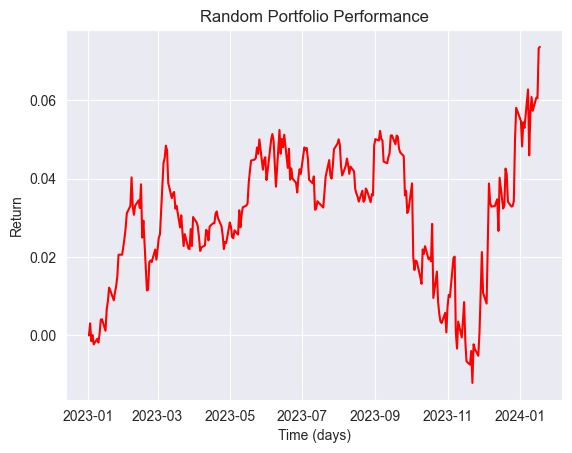

In [22]:
portfolio_performance(ran_port)

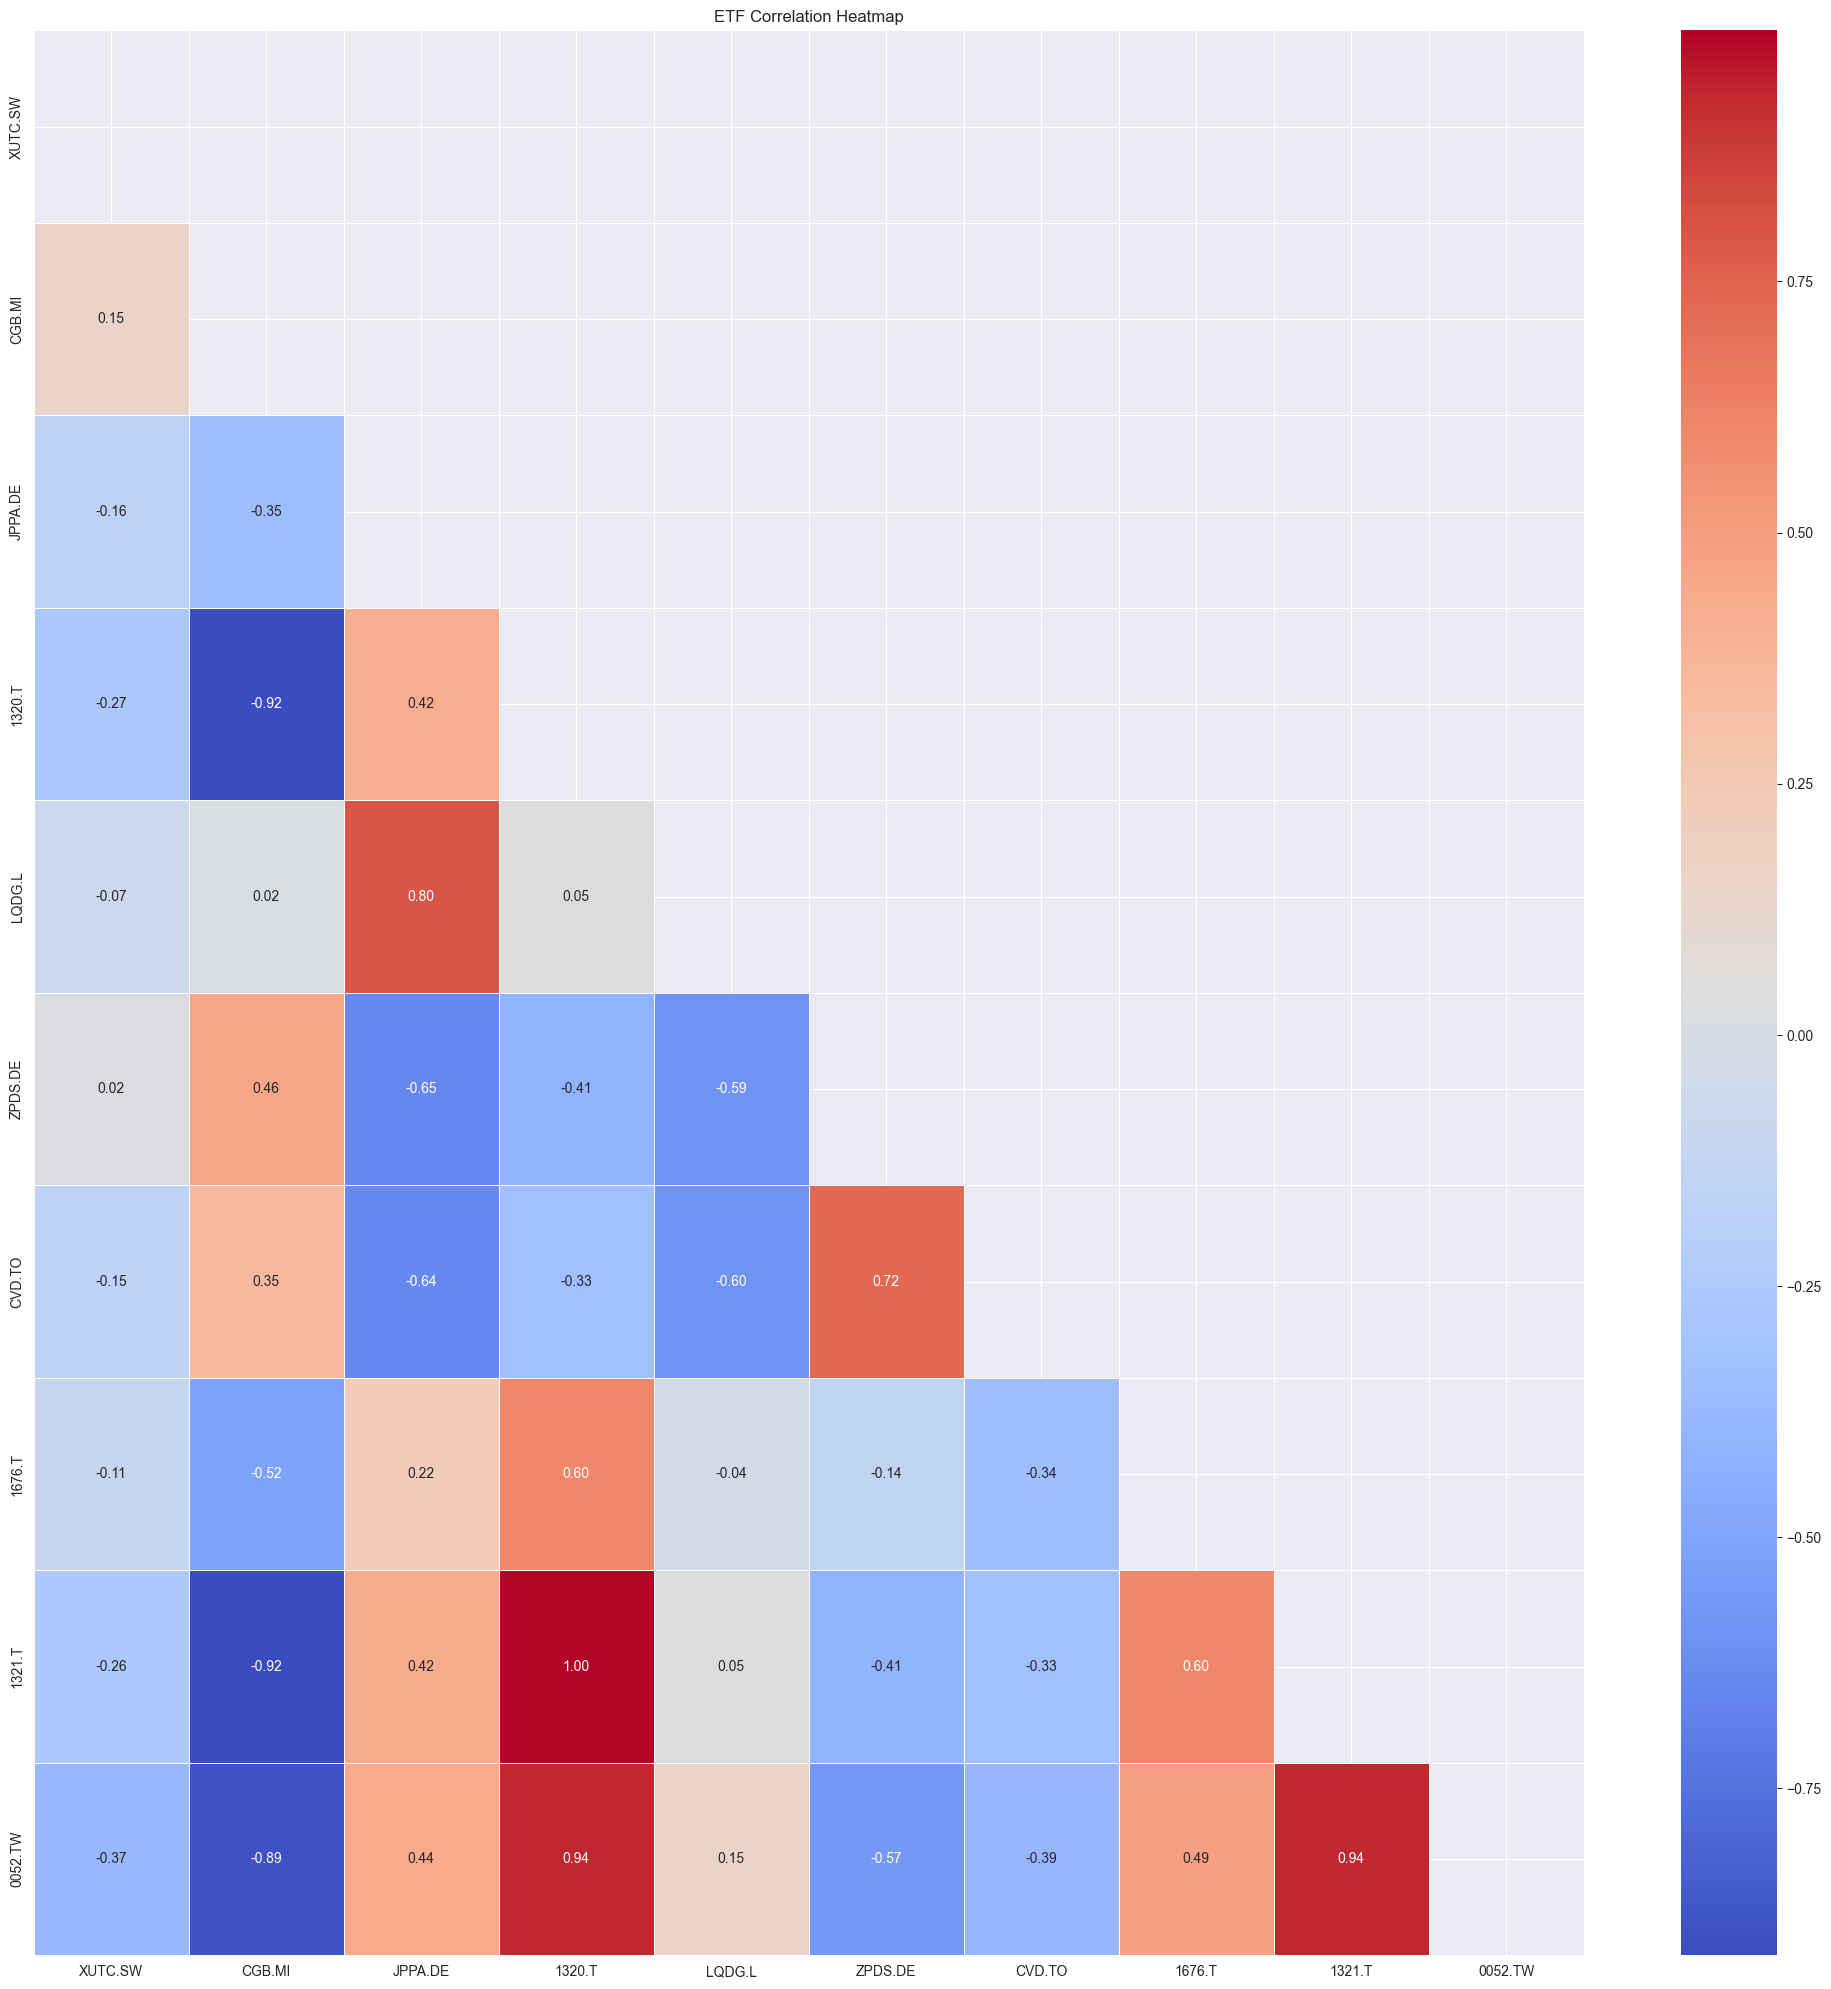

In [23]:
portfolio_corr_matrix(ran_port)

In [24]:
num_ports = 100

all_weights = np.zeros((num_ports,len(ran_port.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)


for ind in range(num_ports):
    sym = list(ran_port.columns)[ind]
    log_ret = np.log(ran_port[sym] / ran_port[sym].shift(1))
    # Create Random Weights
    weights = np.array(np.random.random(10))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    #ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    #vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

C:\Users\Irish\AppData\Local\Temp\ipykernel_11588\3413386568.py:28: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]


IndexError: list index out of range

In [ ]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])
  
from scipy.optimize import minimize
  
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1
  
  # Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1
  
  # By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight
bounds = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

# Initial Guess (equal distribution)
init_guess = [0.0555,0.0555,0.0555,0.0555,0.0555,0.0555,0.0555,0.0555,0.0555,0.0555,0.0555,0.0555,0.0555,0.0555,0.0555,0.0555,0.0555,0.0565]

# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method = 'SLSQP',bounds=bounds,constraints=cons)

opt_results #maximum sharpe value is actually 3.35

In [25]:
import pypfopt

# Read in price data
df = ran_port

# Calculate expected returns and sample covariance
mu = pypfopt.expected_returns.mean_historical_return(df)
S = pypfopt.risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = pypfopt.EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('XUTC.SW', 0.0), ('CGB.MI', 0.0), ('JPPA.DE', 0.16609), ('1320.T', 0.40463), ('LQDG.L', 0.0), ('ZPDS.DE', 0.0), ('CVD.TO', 0.0), ('1676.T', 0.08819), ('1321.T', 0.00142), ('0052.TW', 0.33967)])
Expected annual return: 28.7%
Annual volatility: 9.9%
Sharpe Ratio: 2.70


(0.2868504605925597, 0.09885099002306538, 2.6995223874874106)

AttributeError: module 'pypfopt' has no attribute 'plotting'

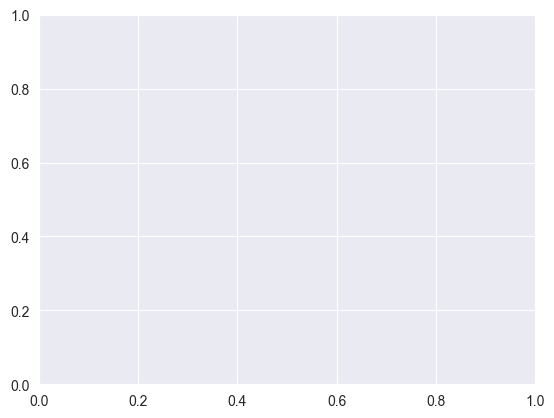

In [26]:
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
pypfopt.plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()